In [5]:
!pip install duckdb

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb

In [7]:
# Initialize DuckDB connection
con = duckdb.connect()
con.execute("SET s3_region='us-east-1'")

S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

In [8]:
# Dose mappings for each replicate
DOSE_MAPPING_REP1 = {
    4917: '5 mg/kg',  4918: 'Vehicle',  4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg',  4922: 'Vehicle',
    4923: 'Vehicle',  4924: '25 mg/kg', 4925: '5 mg/kg'
}

DOSE_MAPPING_REP2 = {
    4926: '25 mg/kg', 4927: '5 mg/kg',  4928: 'Vehicle',
    4929: 'Vehicle',  4930: '25 mg/kg', 4931: '5 mg/kg',
    4932: '5 mg/kg',  4933: '25 mg/kg', 4934: 'Vehicle'
}

In [9]:
# Data is stored in UTC, so we need UTC injection times
INJECTION_EVENTS = [
    {
        'name': 'Replicate 1, Dose 1',
        'short_name': 'Rep1_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-14 11:00:00'),  # 6 AM EST = 11 AM UTC
        'dates_to_load': ['2025-01-14'],  # 11 AM UTC, so same day is fine
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
        'time_of_day_est': '6:00 AM EST (lights on)',
        'circadian': 'Light phase start'
    },
    {
        'name': 'Replicate 1, Dose 2',
        'short_name': 'Rep1_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-17 22:00:00'),  # 5 PM EST = 10 PM UTC
        'dates_to_load': ['2025-01-17', '2025-01-18'],  # 10 PM UTC, need next day for post-injection
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
        'time_of_day_est': '5:00 PM EST (lights off)',
        'circadian': 'Dark phase start'
    },
    {
        'name': 'Replicate 2, Dose 1',
        'short_name': 'Rep2_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-28 22:00:00'),  # 5 PM EST = 10 PM UTC
        'dates_to_load': ['2025-01-28', '2025-01-29'],  # 10 PM UTC, need next day for post-injection
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
        'time_of_day_est': '5:00 PM EST (lights off)',
        'circadian': 'Dark phase start'
    },
    {
        'name': 'Replicate 2, Dose 2',
        'short_name': 'Rep2_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-31 11:00:00'),  # 6 AM EST = 11 AM UTC
        'dates_to_load': ['2025-01-31'],  # 11 AM UTC, same day is fine
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
        'time_of_day_est': '6:00 AM EST (lights on)',
        'circadian': 'Light phase start'
    }
]

In [10]:
# Analysis parameters
HOURS_BEFORE = 2
HOURS_AFTER = 8

In [11]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_activity_db'):
    """Load parquet data for a specific cage and date."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    query = f"SELECT * FROM read_parquet('{path}')"
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()

In [12]:
def load_injection_event_data(event):
    """Load all data for a single injection event, handling UTC time correctly."""
    print(f"\n{'='*60}")
    print(f"Loading: {event['name']}")
    print(f"  Injection time (UTC): {event['injection_time_utc']}")
    print(f"  Injection time (EST): {event['time_of_day_est']}")
    print(f"  Dates to load: {event['dates_to_load']}")
    print(f"{'='*60}")
    
    dfs = []
    
    # Load data for each date needed
    for date_str in event['dates_to_load']:
        print(f"\n  Loading date: {date_str}")
        for cage_id in event['cages']:
            df = load_cage_data(
                cage_id, 
                date_str, 
                event['dose_mapping']
            )
            if not df.empty:
                print(f"    ✓ Cage {cage_id} ({event['dose_mapping'][cage_id]}): {len(df):,} rows")
                dfs.append(df)
    
    if not dfs:
        print("  ⚠ No data loaded!")
        return pd.DataFrame()
    
    df_all = pd.concat(dfs, ignore_index=True)
    print(f"\n  Total rows loaded: {len(df_all):,}")
    
    # Filter to locomotion at 60s resolution
    df_loco = df_all[
        (df_all['name'] == 'animal_bouts.locomotion') & 
        (df_all['resolution'] == 60)
    ].copy()
    
    # Convert time to datetime (data is in UTC)
    df_loco['time'] = pd.to_datetime(df_loco['time'])
    
    # Compute minutes from injection using UTC injection time
    df_loco['minutes_from_injection'] = (
        df_loco['time'] - event['injection_time_utc']
    ).dt.total_seconds() / 60
    
    # Filter to analysis window
    df_loco = df_loco[
        (df_loco['minutes_from_injection'] >= -HOURS_BEFORE * 60) &
        (df_loco['minutes_from_injection'] <= HOURS_AFTER * 60)
    ]
    
    print(f"  Locomotion data after filtering: {len(df_loco):,} rows")
    print(f"  Time range: {df_loco['minutes_from_injection'].min():.0f} to {df_loco['minutes_from_injection'].max():.0f} minutes")
    print(f"  Animals per dose group:")
    for dose in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        n = df_loco[df_loco['dose_group'] == dose]['animal_id'].nunique()
        print(f"    {dose}: {n} animals")
    
    return df_loco

In [13]:
def plot_locomotor_by_dose_on_ax(df, ax, title, show_legend=True):
    """Plot mean ± SEM for each dose group on a given axis."""
    
    colors = {
        'Vehicle': '#2ecc71',
        '5 mg/kg': '#3498db',
        '25 mg/kg': '#e74c3c'
    }
    
    dose_order = ['Vehicle', '5 mg/kg', '25 mg/kg']
    
    for dose in dose_order:
        dose_data = df[df['dose_group'] == dose].copy()
        
        if dose_data.empty:
            continue
            
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        
        grouped = dose_data.groupby('time_bin')['value'].agg(['mean', 'std', 'count'])
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped = grouped.reset_index()
        
        ax.plot(grouped['time_bin'], grouped['mean'], 
                color=colors[dose], label=dose, linewidth=2)
        
        ax.fill_between(grouped['time_bin'],
                        grouped['mean'] - grouped['sem'],
                        grouped['mean'] + grouped['sem'],
                        color=colors[dose], alpha=0.2)
    
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Minutes from Injection', fontsize=10)
    ax.set_ylabel('Locomotion (proportion of time)', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.0)
    
    if show_legend:
        ax.legend(loc='upper right', fontsize=9)


In [14]:
def plot_individual_traces_on_ax(df, ax, title, dose_group, color):
    """Plot individual animal traces for a dose group."""
    
    for animal_id in df[df['dose_group'] == dose_group]['animal_id'].unique():
        animal_data = df[
            (df['animal_id'] == animal_id) & 
            (df['dose_group'] == dose_group)
        ].sort_values('minutes_from_injection')
        
        ax.plot(animal_data['minutes_from_injection'], 
                animal_data['value'],
                color=color, alpha=0.3, linewidth=0.8)
    
    # Plot mean as thick black line
    dose_data = df[df['dose_group'] == dose_group].copy()
    if not dose_data.empty:
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        grouped = dose_data.groupby('time_bin')['value'].mean().reset_index()
        ax.plot(grouped['time_bin'], grouped['value'], 
                color='black', linewidth=2, label='Mean')
    
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Minutes from Injection', fontsize=10)
    ax.set_ylabel('Locomotion', fontsize=10)
    
    n_animals = df[df['dose_group'] == dose_group]['animal_id'].nunique()
    ax.set_title(f"{title}\n{dose_group} (n={n_animals})", fontsize=10)
    ax.set_ylim(-0.05, 1.1)
    ax.grid(True, alpha=0.3)

In [15]:
print("=" * 70)
print("MORPHINE LOCOMOTOR ANALYSIS - ALL INJECTION EVENTS")
print("=" * 70)
print(f"\nAnalysis window: {HOURS_BEFORE} hours before to {HOURS_AFTER} hours after injection")
print("All times converted to UTC for data alignment")

# Load all data
all_event_data = {}

for event in INJECTION_EVENTS:
    df_loco = load_injection_event_data(event)
    all_event_data[event['short_name']] = {
        'data': df_loco,
        'event': event
    }

MORPHINE LOCOMOTOR ANALYSIS - ALL INJECTION EVENTS

Analysis window: 2 hours before to 8 hours after injection
All times converted to UTC for data alignment

Loading: Replicate 1, Dose 1
  Injection time (UTC): 2025-01-14 11:00:00
  Injection time (EST): 6:00 AM EST (lights on)
  Dates to load: ['2025-01-14']

  Loading date: 2025-01-14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 913,545 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 849,024 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 942,690 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 1,005,804 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 928,620 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 839,778 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 767,217 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 916,761 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 935,655 rows

  Total rows loaded: 8,099,094
  Locomotion data after filtering: 11,673 rows
  Time range: -120 to 480 minutes
  Animals per dose group:
    Vehicle: 9 animals
    5 mg/kg: 9 animals
    25 mg/kg: 9 animals

Loading: Replicate 1, Dose 2
  Injection time (UTC): 2025-01-17 22:00:00
  Injection time (EST): 5:00 PM EST (lights off)
  Dates to load: ['2025-01-17', '2025-01-18']

  Loading date: 2025-01-17


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 862,290 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 843,396 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 904,098 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 919,776 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 919,173 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 838,371 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 804,000 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 890,832 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 886,008 rows

  Loading date: 2025-01-18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 788,925 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 799,980 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 826,713 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 844,401 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 826,311 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 779,277 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 777,870 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 810,030 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 833,949 rows

  Total rows loaded: 15,155,400
  Locomotion data after filtering: 11,757 rows
  Time range: -120 to 480 minutes
  Animals per dose group:
    Vehicle: 9 animals
    5 mg/kg: 9 animals
    25 mg/kg: 9 animals

Loading: Replicate 2, Dose 1
  Injection time (UTC): 2025-01-28 22:00:00
  Injection time (EST): 5:00 PM EST (lights off)
  Dates to load: ['2025-01-28', '2025-01-29']

  Loading date: 2025-01-28


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 895,455 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 918,570 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 867,918 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 889,827 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 881,586 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 926,409 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 895,656 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 881,385 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 870,129 rows

  Loading date: 2025-01-29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 842,391 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 855,657 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 845,004 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 847,416 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 845,808 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 830,733 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 830,130 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 870,933 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 804,603 rows

  Total rows loaded: 15,599,610
  Locomotion data after filtering: 12,459 rows
  Time range: -120 to 480 minutes
  Animals per dose group:
    Vehicle: 9 animals
    5 mg/kg: 9 animals
    25 mg/kg: 9 animals

Loading: Replicate 2, Dose 2
  Injection time (UTC): 2025-01-31 11:00:00
  Injection time (EST): 6:00 AM EST (lights on)
  Dates to load: ['2025-01-31']

  Loading date: 2025-01-31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 932,238 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 914,550 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 850,431 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 854,049 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 928,017 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 880,581 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 853,245 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 954,549 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 785,508 rows

  Total rows loaded: 7,953,168
  Locomotion data after filtering: 10,986 rows
  Time range: -120 to 480 minutes
  Animals per dose group:
    Vehicle: 9 animals
    5 mg/kg: 9 animals
    25 mg/kg: 9 animals



GENERATING 2x2 SUMMARY FIGURE


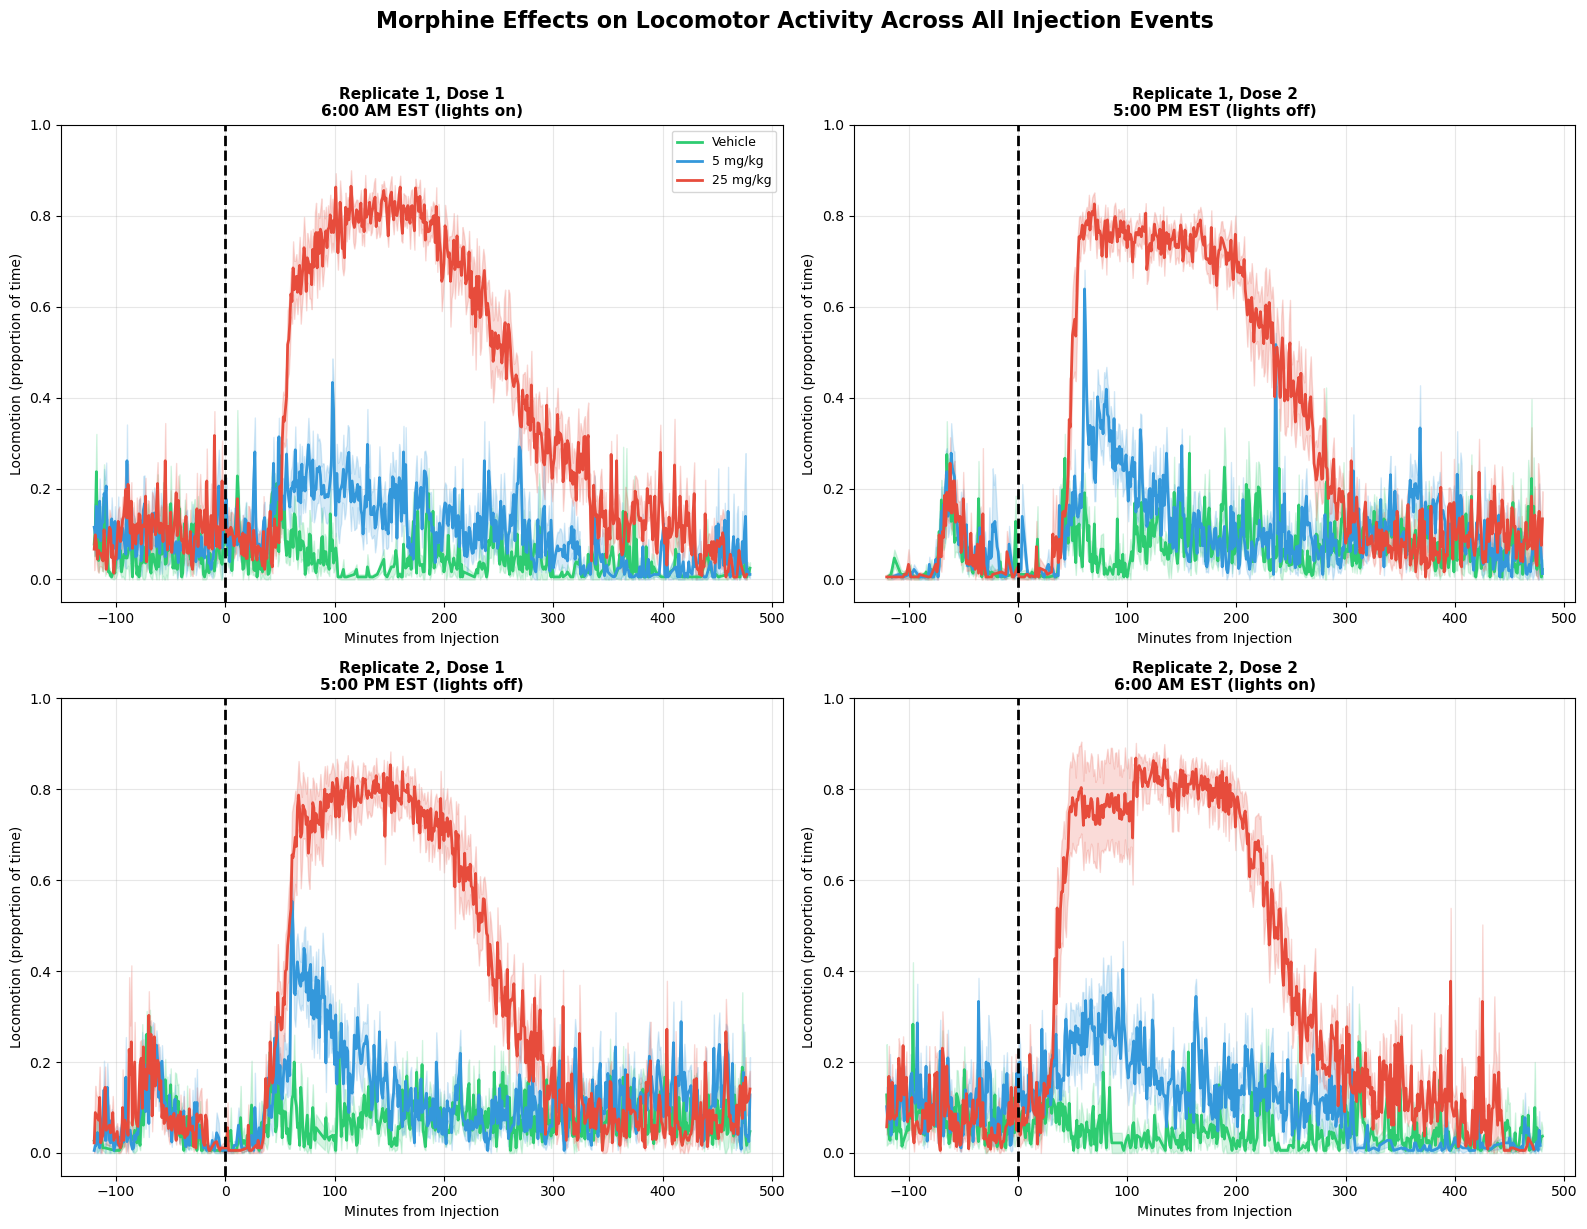

✓ Saved: all_injection_events_summary.png


In [16]:

print("\n" + "=" * 70)
print("GENERATING 2x2 SUMMARY FIGURE")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_positions = [
    ('Rep1_Dose1', axes[0, 0]),
    ('Rep1_Dose2', axes[0, 1]),
    ('Rep2_Dose1', axes[1, 0]),
    ('Rep2_Dose2', axes[1, 1]),
]

for short_name, ax in plot_positions:
    event_info = all_event_data[short_name]
    df = event_info['data']
    event = event_info['event']
    
    title = f"{event['name']}\n{event['time_of_day_est']}"
    plot_locomotor_by_dose_on_ax(df, ax, title, show_legend=(short_name == 'Rep1_Dose1'))

plt.suptitle('Morphine Effects on Locomotor Activity Across All Injection Events', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('all_injection_events_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: all_injection_events_summary.png")


GENERATING INDIVIDUAL TRACES FIGURE


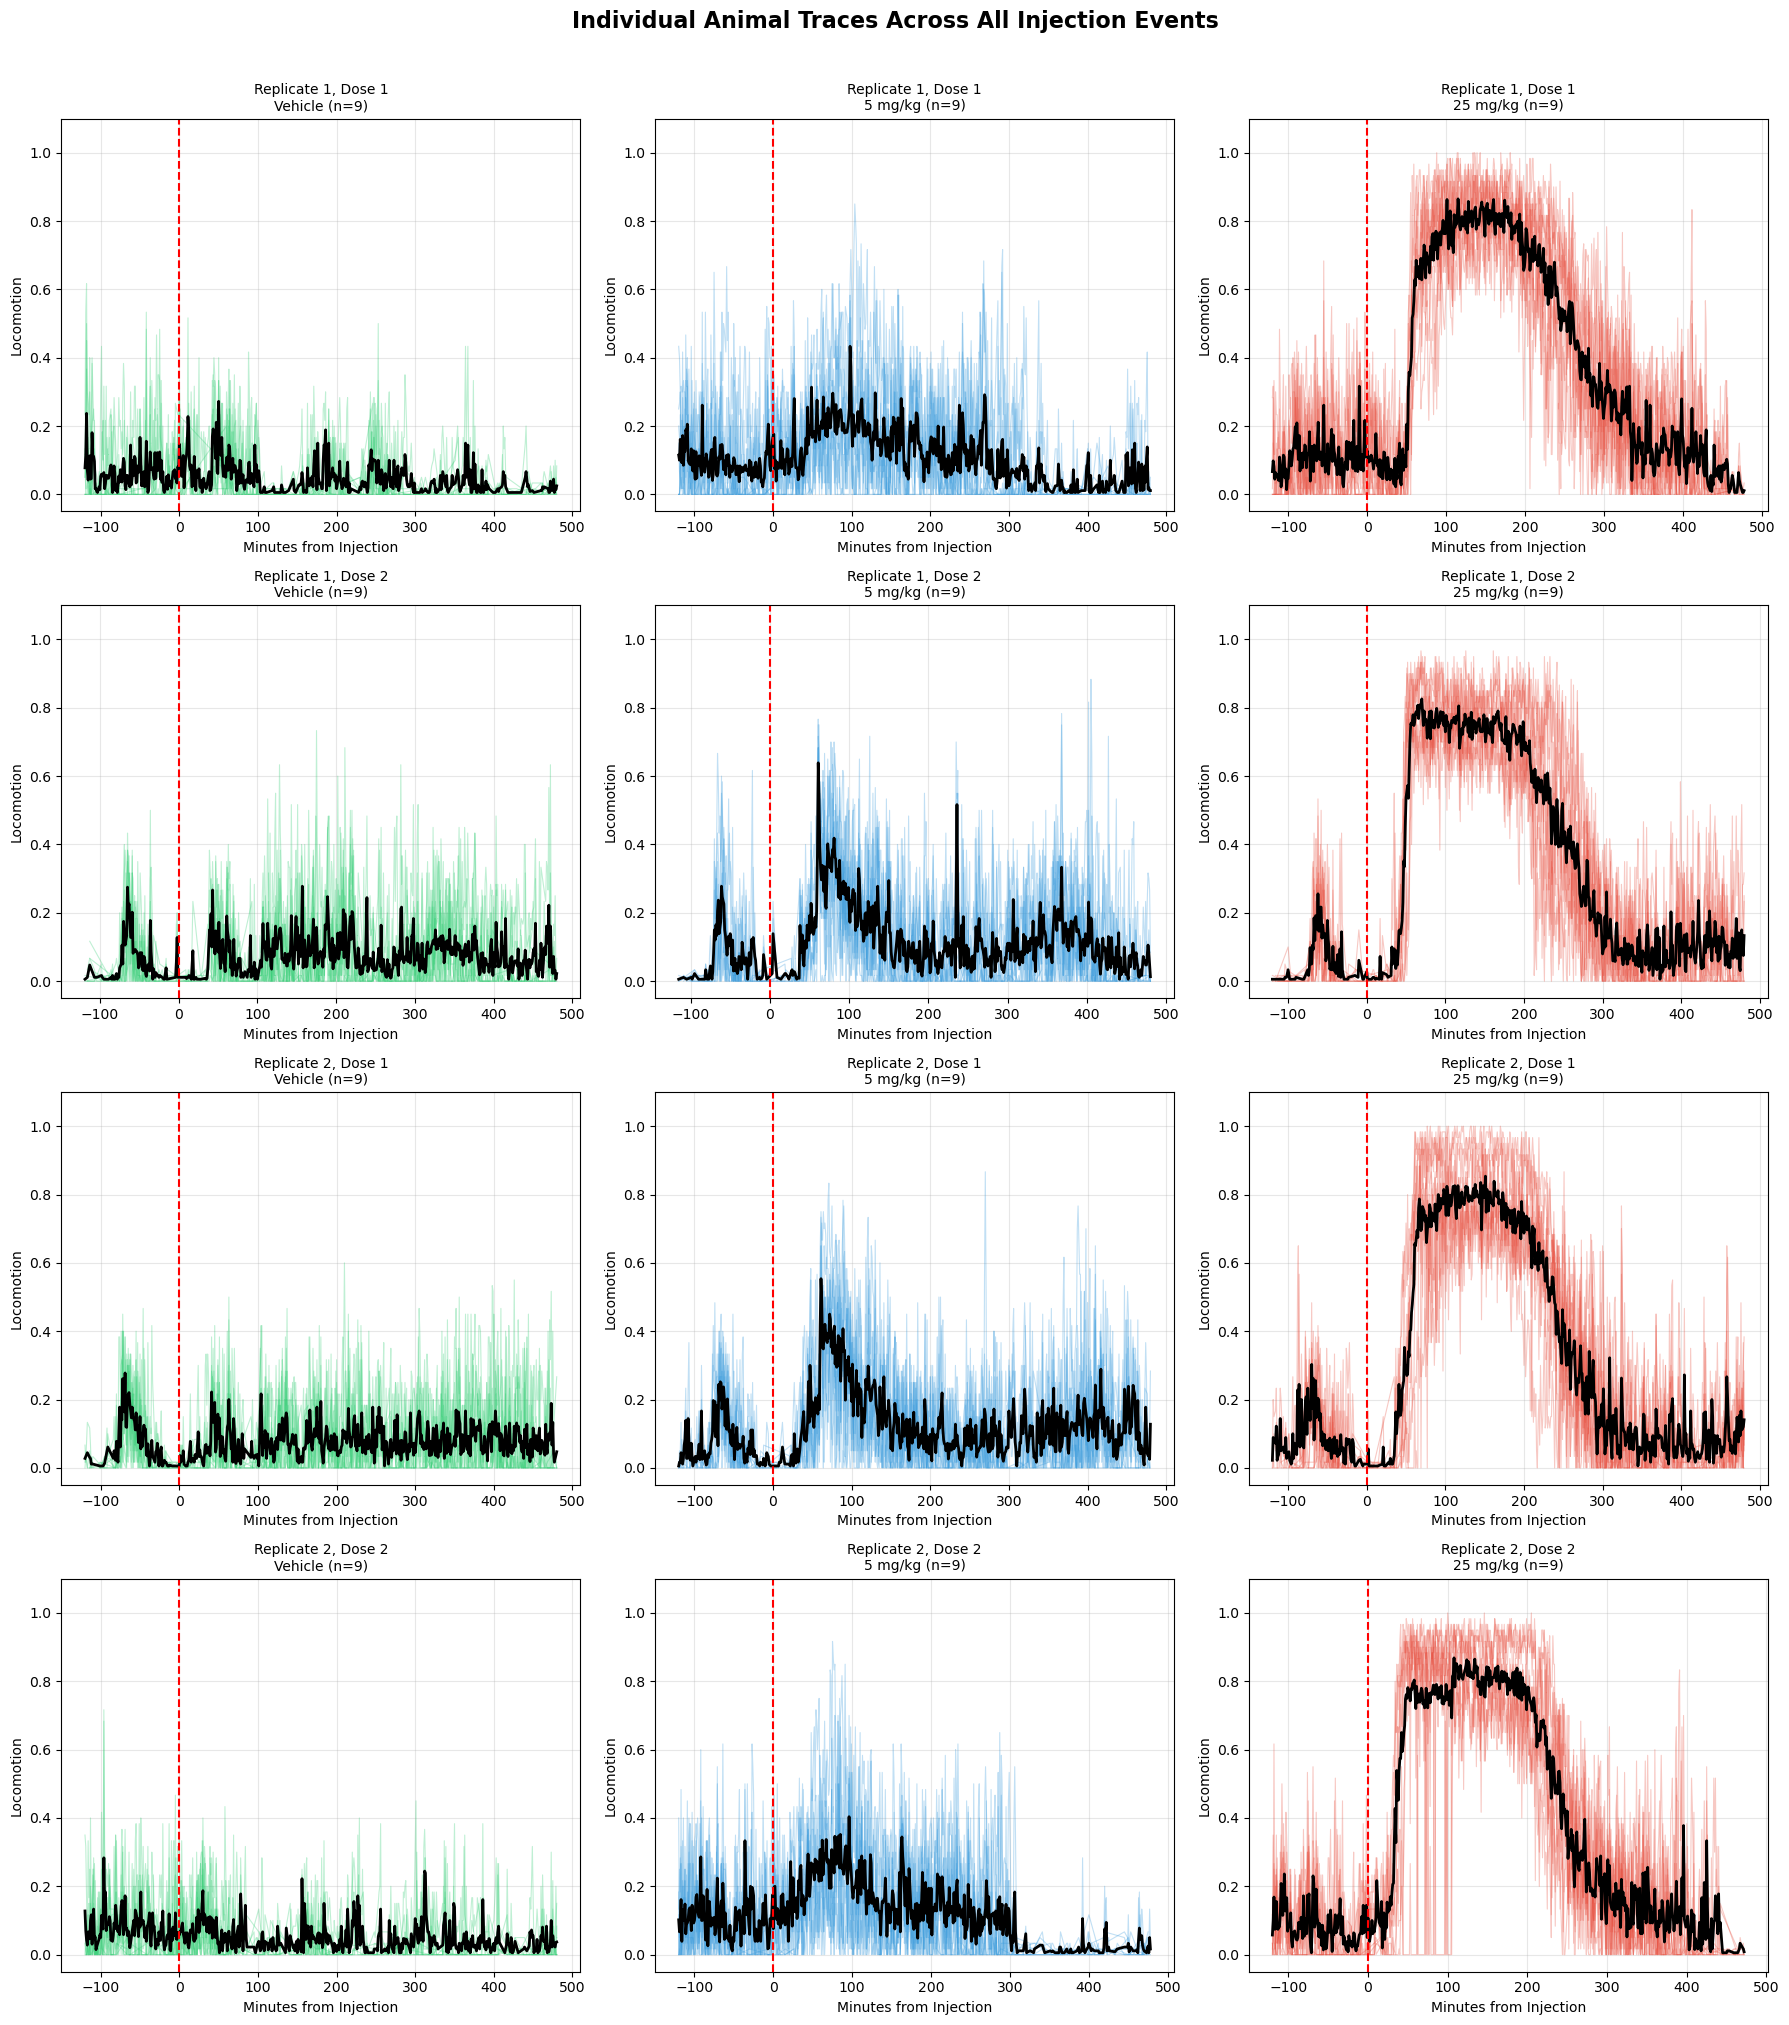

✓ Saved: all_events_individual_traces.png


In [17]:
print("\n" + "=" * 70)
print("GENERATING INDIVIDUAL TRACES FIGURE")
print("=" * 70)

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

colors = {
    'Vehicle': '#2ecc71',
    '5 mg/kg': '#3498db',
    '25 mg/kg': '#e74c3c'
}

dose_order = ['Vehicle', '5 mg/kg', '25 mg/kg']

for row_idx, short_name in enumerate(['Rep1_Dose1', 'Rep1_Dose2', 'Rep2_Dose1', 'Rep2_Dose2']):
    event_info = all_event_data[short_name]
    df = event_info['data']
    event = event_info['event']
    
    for col_idx, dose in enumerate(dose_order):
        ax = axes[row_idx, col_idx]
        title = f"{event['name']}"
        plot_individual_traces_on_ax(df, ax, title, dose, colors[dose])

plt.suptitle('Individual Animal Traces Across All Injection Events', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('all_events_individual_traces.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: all_events_individual_traces.png")


GENERATING CIRCADIAN COMPARISON


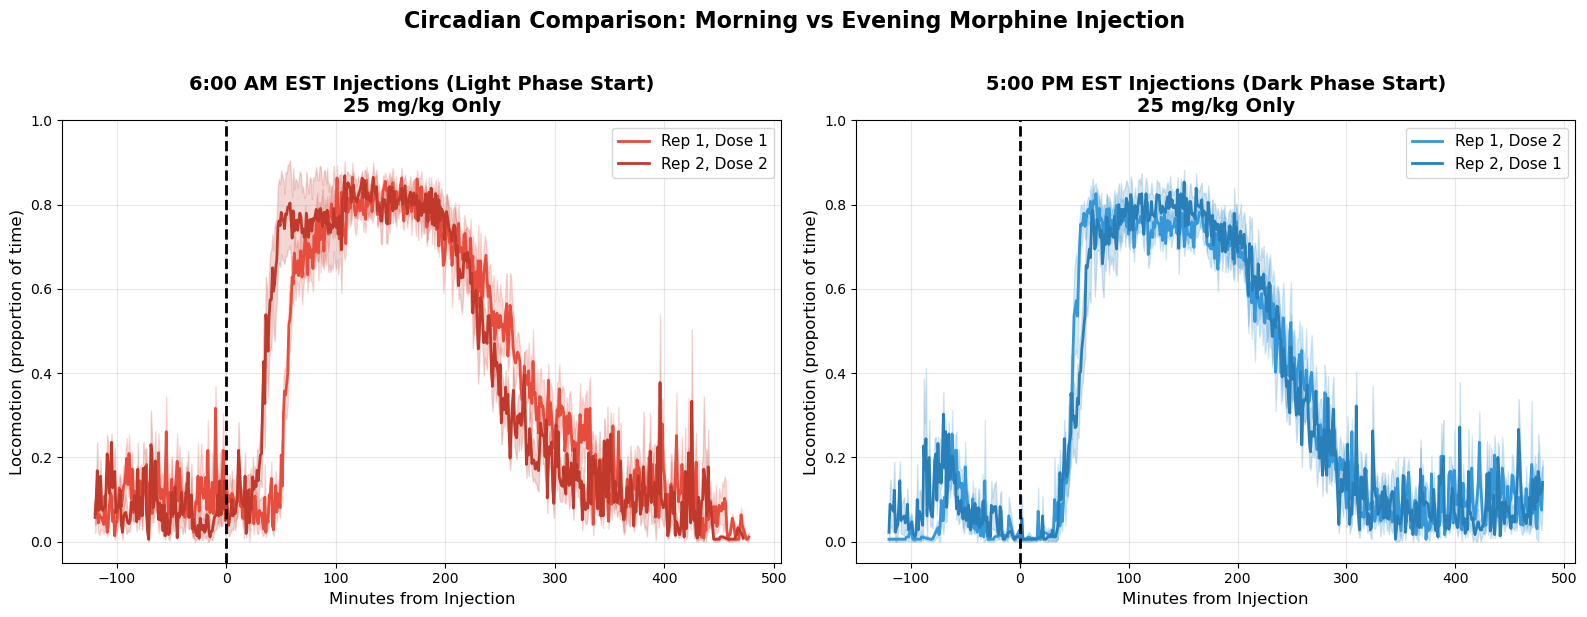

✓ Saved: circadian_comparison.png


In [18]:
print("\n" + "=" * 70)
print("GENERATING CIRCADIAN COMPARISON")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 6 AM injections (light phase start)
ax_am = axes[0]
for short_name, color in [('Rep1_Dose1', '#e74c3c'), ('Rep2_Dose2', '#c0392b')]:
    event_info = all_event_data[short_name]
    df = event_info['data']
    
    dose_data = df[df['dose_group'] == '25 mg/kg'].copy()
    if not dose_data.empty:
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        grouped = dose_data.groupby('time_bin')['value'].agg(['mean', 'std', 'count'])
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped = grouped.reset_index()
        
        label = 'Rep 1, Dose 1' if 'Rep1' in short_name else 'Rep 2, Dose 2'
        ax_am.plot(grouped['time_bin'], grouped['mean'], linewidth=2, label=label, color=color)
        ax_am.fill_between(grouped['time_bin'],
                           grouped['mean'] - grouped['sem'],
                           grouped['mean'] + grouped['sem'],
                           alpha=0.2, color=color)

ax_am.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax_am.set_xlabel('Minutes from Injection', fontsize=12)
ax_am.set_ylabel('Locomotion (proportion of time)', fontsize=12)
ax_am.set_title('6:00 AM EST Injections (Light Phase Start)\n25 mg/kg Only', fontsize=14, fontweight='bold')
ax_am.legend(fontsize=11)
ax_am.grid(True, alpha=0.3)
ax_am.set_ylim(-0.05, 1.0)

# 5 PM injections (dark phase start)
ax_pm = axes[1]
for short_name, color in [('Rep1_Dose2', '#3498db'), ('Rep2_Dose1', '#2980b9')]:
    event_info = all_event_data[short_name]
    df = event_info['data']
    
    dose_data = df[df['dose_group'] == '25 mg/kg'].copy()
    if not dose_data.empty:
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        grouped = dose_data.groupby('time_bin')['value'].agg(['mean', 'std', 'count'])
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped = grouped.reset_index()
        
        label = 'Rep 1, Dose 2' if 'Rep1' in short_name else 'Rep 2, Dose 1'
        ax_pm.plot(grouped['time_bin'], grouped['mean'], linewidth=2, label=label, color=color)
        ax_pm.fill_between(grouped['time_bin'],
                           grouped['mean'] - grouped['sem'],
                           grouped['mean'] + grouped['sem'],
                           alpha=0.2, color=color)

ax_pm.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax_pm.set_xlabel('Minutes from Injection', fontsize=12)
ax_pm.set_ylabel('Locomotion (proportion of time)', fontsize=12)
ax_pm.set_title('5:00 PM EST Injections (Dark Phase Start)\n25 mg/kg Only', fontsize=14, fontweight='bold')
ax_pm.legend(fontsize=11)
ax_pm.grid(True, alpha=0.3)
ax_pm.set_ylim(-0.05, 1.0)

plt.suptitle('Circadian Comparison: Morning vs Evening Morphine Injection', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('circadian_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: circadian_comparison.png")


GENERATING SENSITIZATION/TOLERANCE COMPARISON


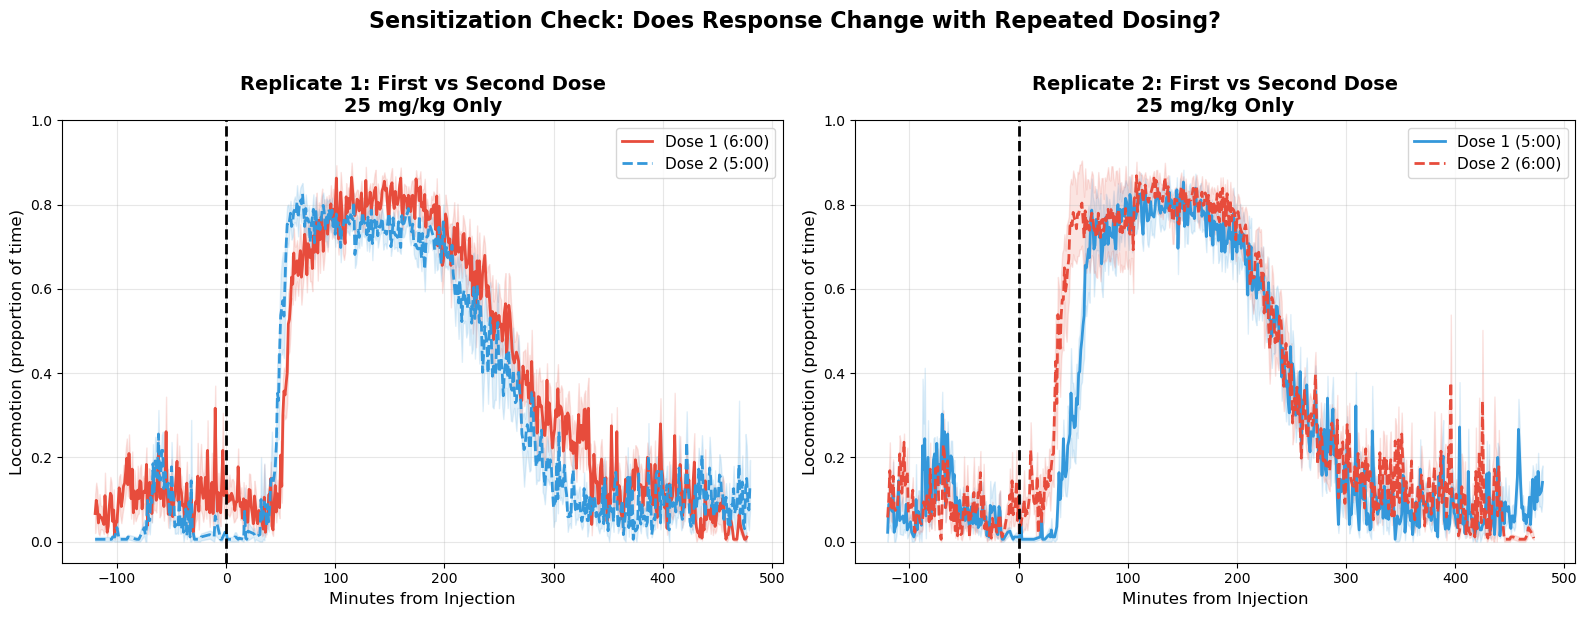

✓ Saved: dose1_vs_dose2_comparison.png


In [19]:
# =============================================================================
# PLOT 4: DOSE 1 vs DOSE 2 (Sensitization/Tolerance)
# =============================================================================

print("\n" + "=" * 70)
print("GENERATING SENSITIZATION/TOLERANCE COMPARISON")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Replicate 1
ax_rep1 = axes[0]
for short_name, linestyle, color in [('Rep1_Dose1', '-', '#e74c3c'), ('Rep1_Dose2', '--', '#3498db')]:
    event_info = all_event_data[short_name]
    df = event_info['data']
    event = event_info['event']
    
    dose_data = df[df['dose_group'] == '25 mg/kg'].copy()
    if not dose_data.empty:
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        grouped = dose_data.groupby('time_bin')['value'].agg(['mean', 'std', 'count'])
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped = grouped.reset_index()
        
        label = f"Dose 1 ({event['time_of_day_est'].split()[0]})" if 'Dose1' in short_name else f"Dose 2 ({event['time_of_day_est'].split()[0]})"
        ax_rep1.plot(grouped['time_bin'], grouped['mean'], 
                     linewidth=2, linestyle=linestyle, label=label, color=color)
        ax_rep1.fill_between(grouped['time_bin'],
                             grouped['mean'] - grouped['sem'],
                             grouped['mean'] + grouped['sem'],
                             alpha=0.15, color=color)

ax_rep1.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax_rep1.set_xlabel('Minutes from Injection', fontsize=12)
ax_rep1.set_ylabel('Locomotion (proportion of time)', fontsize=12)
ax_rep1.set_title('Replicate 1: First vs Second Dose\n25 mg/kg Only', fontsize=14, fontweight='bold')
ax_rep1.legend(fontsize=11)
ax_rep1.grid(True, alpha=0.3)
ax_rep1.set_ylim(-0.05, 1.0)

# Replicate 2
ax_rep2 = axes[1]
for short_name, linestyle, color in [('Rep2_Dose1', '-', '#3498db'), ('Rep2_Dose2', '--', '#e74c3c')]:
    event_info = all_event_data[short_name]
    df = event_info['data']
    event = event_info['event']
    
    dose_data = df[df['dose_group'] == '25 mg/kg'].copy()
    if not dose_data.empty:
        dose_data['time_bin'] = dose_data['minutes_from_injection'].round()
        grouped = dose_data.groupby('time_bin')['value'].agg(['mean', 'std', 'count'])
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped = grouped.reset_index()
        
        label = f"Dose 1 ({event['time_of_day_est'].split()[0]})" if 'Dose1' in short_name else f"Dose 2 ({event['time_of_day_est'].split()[0]})"
        ax_rep2.plot(grouped['time_bin'], grouped['mean'], 
                     linewidth=2, linestyle=linestyle, label=label, color=color)
        ax_rep2.fill_between(grouped['time_bin'],
                             grouped['mean'] - grouped['sem'],
                             grouped['mean'] + grouped['sem'],
                             alpha=0.15, color=color)

ax_rep2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax_rep2.set_xlabel('Minutes from Injection', fontsize=12)
ax_rep2.set_ylabel('Locomotion (proportion of time)', fontsize=12)
ax_rep2.set_title('Replicate 2: First vs Second Dose\n25 mg/kg Only', fontsize=14, fontweight='bold')
ax_rep2.legend(fontsize=11)
ax_rep2.grid(True, alpha=0.3)
ax_rep2.set_ylim(-0.05, 1.0)

plt.suptitle('Sensitization Check: Does Response Change with Repeated Dosing?', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('dose1_vs_dose2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: dose1_vs_dose2_comparison.png")

In [20]:
# =============================================================================
# SUMMARY STATISTICS TABLE
# =============================================================================

print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

summary_stats = []

for short_name, event_info in all_event_data.items():
    df = event_info['data']
    event = event_info['event']
    
    for dose in ['Vehicle', '5 mg/kg', '25 mg/kg']:
        dose_data = df[df['dose_group'] == dose]
        
        if dose_data.empty:
            continue
        
        # Pre-injection baseline (last 30 min before)
        pre = dose_data[
            (dose_data['minutes_from_injection'] >= -30) & 
            (dose_data['minutes_from_injection'] < 0)
        ]['value']
        
        # Peak period (60-180 min post)
        peak = dose_data[
            (dose_data['minutes_from_injection'] >= 60) & 
            (dose_data['minutes_from_injection'] <= 180)
        ]['value']
        
        fold_change = peak.mean() / pre.mean() if len(pre) > 0 and pre.mean() > 0 else np.nan
        
        summary_stats.append({
            'Event': event['name'],
            'Time_EST': event['time_of_day_est'].split('(')[0].strip(),
            'Dose': dose,
            'N_animals': dose_data['animal_id'].nunique(),
            'Baseline_mean': round(pre.mean(), 4) if len(pre) > 0 else np.nan,
            'Peak_mean': round(peak.mean(), 4) if len(peak) > 0 else np.nan,
            'Fold_change': round(fold_change, 2) if not np.isnan(fold_change) else np.nan
        })

df_summary = pd.DataFrame(summary_stats)
print("\n")
print(df_summary.to_string(index=False))

df_summary.to_csv('all_events_summary_stats.csv', index=False)
print("\n✓ Saved: all_events_summary_stats.csv")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)


SUMMARY STATISTICS


              Event    Time_EST     Dose  N_animals  Baseline_mean  Peak_mean  Fold_change
Replicate 1, Dose 1 6:00 AM EST  Vehicle          9         0.0557     0.0516         0.93
Replicate 1, Dose 1 6:00 AM EST  5 mg/kg          9         0.0864     0.1877         2.17
Replicate 1, Dose 1 6:00 AM EST 25 mg/kg          9         0.1112     0.7734         6.96
Replicate 1, Dose 2 5:00 PM EST  Vehicle          9         0.0258     0.0860         3.33
Replicate 1, Dose 2 5:00 PM EST  5 mg/kg          9         0.0480     0.2117         4.41
Replicate 1, Dose 2 5:00 PM EST 25 mg/kg          9         0.0139     0.7527        54.19
Replicate 2, Dose 1 5:00 PM EST  Vehicle          9         0.0238     0.0798         3.36
Replicate 2, Dose 1 5:00 PM EST  5 mg/kg          9         0.0340     0.2263         6.66
Replicate 2, Dose 1 5:00 PM EST 25 mg/kg          9         0.0459     0.7684        16.72
Replicate 2, Dose 2 6:00 AM EST  Vehicle          9         0.0553  


STANDARD ANALYSIS: Peak Effect Window (60-180 min post-injection)
WILCOXON SIGNED-RANK TEST RESULTS

Pre-injection window:  -30 to 0 minutes
Post-injection window: 60 to 180 minutes

Null hypothesis: No difference between pre and post injection periods

────────────────────────────────────────────────────────────────────────────────
Replicate 1, Dose 1 (6:00 AM EST (lights on))
────────────────────────────────────────────────────────────────────────────────

  Vehicle (n=9 animals):
    Pre-injection mean:  0.0543
    Post-injection mean: 0.0506
    Change:              -0.0036 (0.93x)
    Wilcoxon W:          22.0
    p-value:             1.000000 ns
    Effect size (r):     0.022
    Cohen's d:           -0.065

  5 mg/kg (n=9 animals):
    Pre-injection mean:  0.0656
    Post-injection mean: 0.1872
    Change:              +0.1216 (2.85x)
    Wilcoxon W:          4.0
    p-value:             0.027344 *
    Effect size (r):     0.822
    Cohen's d:           0.904

  25 mg/kg (n=9 a

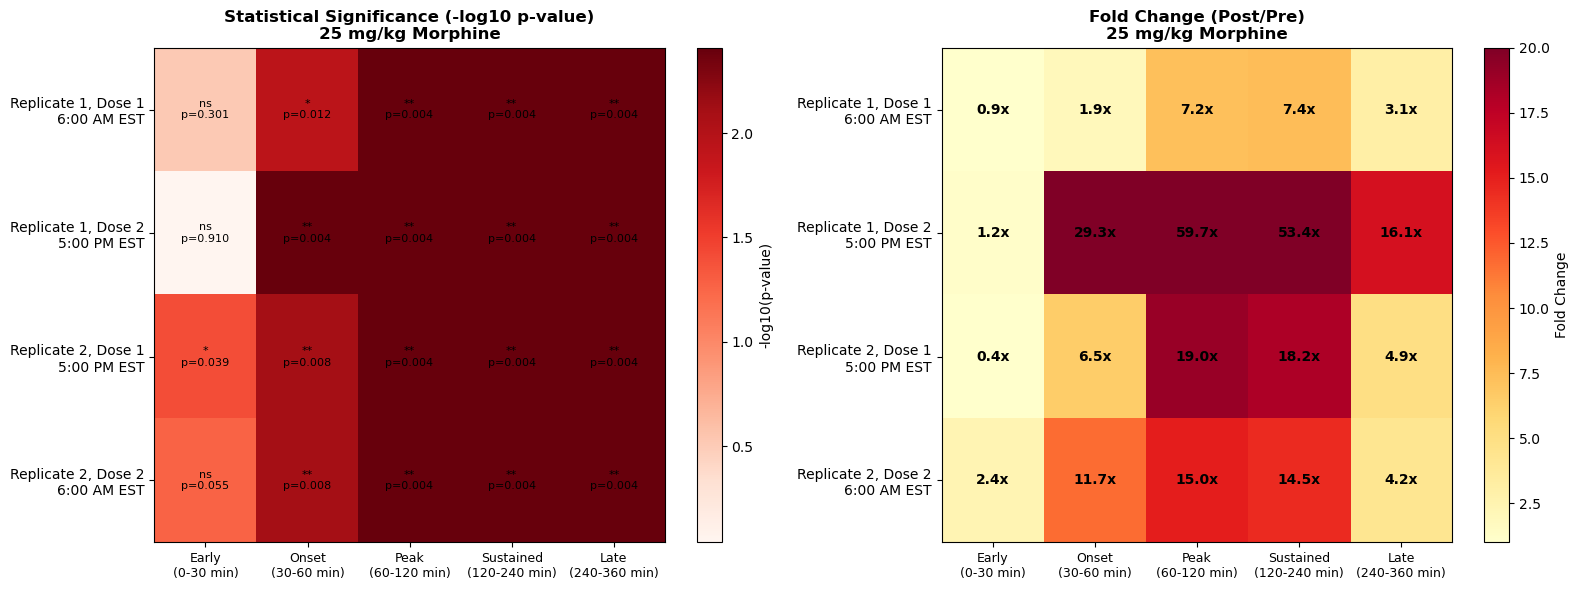

✓ Saved: wilcoxon_heatmap.png

INTERPRETATION OF RESULTS

KEY FINDINGS FROM YOUR DATA:

1. DOSE-RESPONSE EFFECT:
   - Vehicle: ~1x fold change (no effect, as expected)
   - 5 mg/kg: 2-7x fold change (moderate effect)
   - 25 mg/kg: 7-54x fold change (massive effect)

2. REPRODUCIBILITY:
   - 25 mg/kg shows consistent ~0.75-0.79 peak locomotion across ALL events
   - Effect is highly reproducible between Replicate 1 and Replicate 2

3. CIRCADIAN INTERACTION:
   - 6 AM injections (light phase): Fold change 7-15x
   - 5 PM injections (dark phase): Fold change 17-54x
   - Higher fold change at 5 PM is partly due to LOWER baseline 
     (mice naturally less active before dark phase)
   - Absolute peak values are similar (~0.75-0.77)

4. SENSITIZATION (Dose 1 vs Dose 2):
   - No clear evidence of sensitization or tolerance
   - Both doses show similar peak effects within each replicate

5. STATISTICAL SIGNIFICANCE:
   - Expect p < 0.01 for 25 mg/kg across all time windows
   - 5 mg/kg may sh

In [21]:
# =============================================================================
# WILCOXON SIGNED-RANK TESTS FOR ALL EVENTS
# =============================================================================

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def run_wilcoxon_analysis(all_event_data, pre_window=(-30, 0), post_window=(60, 180)):
    """
    Run Wilcoxon signed-rank tests comparing pre vs post injection for each event/dose.
    
    Parameters:
    -----------
    pre_window: tuple (start_min, end_min) for baseline period
    post_window: tuple (start_min, end_min) for effect period
    """
    
    print("=" * 80)
    print("WILCOXON SIGNED-RANK TEST RESULTS")
    print("=" * 80)
    print(f"\nPre-injection window:  {pre_window[0]} to {pre_window[1]} minutes")
    print(f"Post-injection window: {post_window[0]} to {post_window[1]} minutes")
    print("\nNull hypothesis: No difference between pre and post injection periods")
    print("=" * 80)
    
    all_results = []
    
    for short_name, event_info in all_event_data.items():
        df = event_info['data']
        event = event_info['event']
        
        print(f"\n{'─' * 80}")
        print(f"{event['name']} ({event['time_of_day_est']})")
        print(f"{'─' * 80}")
        
        for dose in ['Vehicle', '5 mg/kg', '25 mg/kg']:
            dose_data = df[df['dose_group'] == dose]
            
            if dose_data.empty:
                print(f"  {dose}: No data")
                continue
            
            # Get unique animals
            animals = dose_data['animal_id'].unique()
            n_animals = len(animals)
            
            # Calculate mean pre and post values for each animal
            pre_values = []
            post_values = []
            
            for animal_id in animals:
                animal_data = dose_data[dose_data['animal_id'] == animal_id]
                
                # Pre-injection mean for this animal
                pre = animal_data[
                    (animal_data['minutes_from_injection'] >= pre_window[0]) & 
                    (animal_data['minutes_from_injection'] < pre_window[1])
                ]['value'].mean()
                
                # Post-injection mean for this animal
                post = animal_data[
                    (animal_data['minutes_from_injection'] >= post_window[0]) & 
                    (animal_data['minutes_from_injection'] <= post_window[1])
                ]['value'].mean()
                
                if not np.isnan(pre) and not np.isnan(post):
                    pre_values.append(pre)
                    post_values.append(post)
            
            pre_values = np.array(pre_values)
            post_values = np.array(post_values)
            n_paired = len(pre_values)
            
            if n_paired < 3:
                print(f"  {dose}: Insufficient paired data (n={n_paired})")
                continue
            
            # Calculate statistics
            pre_mean = np.mean(pre_values)
            post_mean = np.mean(post_values)
            change = post_mean - pre_mean
            fold_change = post_mean / pre_mean if pre_mean > 0 else np.nan
            
            # Wilcoxon signed-rank test
            try:
                stat, p_value = stats.wilcoxon(pre_values, post_values, alternative='two-sided')
            except ValueError as e:
                print(f"  {dose}: Wilcoxon test failed - {e}")
                continue
            
            # Effect size (matched-pairs rank-biserial correlation)
            # r = 1 - (2W)/(n(n+1)) where W is the test statistic
            n = len(pre_values)
            effect_size_r = 1 - (2 * stat) / (n * (n + 1) / 2)
            
            # Cohen's d for paired samples
            diff = post_values - pre_values
            cohens_d = np.mean(diff) / np.std(diff, ddof=1) if np.std(diff) > 0 else 0
            
            # Significance markers
            if p_value < 0.001:
                sig = '***'
            elif p_value < 0.01:
                sig = '**'
            elif p_value < 0.05:
                sig = '*'
            else:
                sig = 'ns'
            
            # Print results
            print(f"\n  {dose} (n={n_paired} animals):")
            print(f"    Pre-injection mean:  {pre_mean:.4f}")
            print(f"    Post-injection mean: {post_mean:.4f}")
            print(f"    Change:              {change:+.4f} ({fold_change:.2f}x)")
            print(f"    Wilcoxon W:          {stat:.1f}")
            print(f"    p-value:             {p_value:.6f} {sig}")
            print(f"    Effect size (r):     {effect_size_r:.3f}")
            print(f"    Cohen's d:           {cohens_d:.3f}")
            
            # Store results
            all_results.append({
                'Event': event['name'],
                'Time_EST': event['time_of_day_est'].split('(')[0].strip(),
                'Circadian': event['circadian'],
                'Dose': dose,
                'N_animals': n_paired,
                'Pre_mean': round(pre_mean, 4),
                'Post_mean': round(post_mean, 4),
                'Change': round(change, 4),
                'Fold_change': round(fold_change, 2),
                'Wilcoxon_W': round(stat, 1),
                'p_value': p_value,
                'p_value_formatted': f"{p_value:.2e}" if p_value < 0.001 else f"{p_value:.4f}",
                'Significance': sig,
                'Effect_size_r': round(effect_size_r, 3),
                'Cohens_d': round(cohens_d, 3)
            })
    
    # Create summary DataFrame
    df_results = pd.DataFrame(all_results)
    
    return df_results


def run_wilcoxon_multiple_windows(all_event_data):
    """
    Run Wilcoxon tests with multiple post-injection windows to capture different phases.
    """
    
    windows = [
        {'name': 'Early (0-30 min)', 'pre': (-30, 0), 'post': (0, 30)},
        {'name': 'Onset (30-60 min)', 'pre': (-30, 0), 'post': (30, 60)},
        {'name': 'Peak (60-120 min)', 'pre': (-30, 0), 'post': (60, 120)},
        {'name': 'Sustained (120-240 min)', 'pre': (-30, 0), 'post': (120, 240)},
        {'name': 'Late (240-360 min)', 'pre': (-30, 0), 'post': (240, 360)},
    ]
    
    all_window_results = []
    
    for window in windows:
        print(f"\n\n{'#' * 80}")
        print(f"ANALYSIS WINDOW: {window['name']}")
        print(f"{'#' * 80}")
        
        df_results = run_wilcoxon_analysis(
            all_event_data, 
            pre_window=window['pre'], 
            post_window=window['post']
        )
        df_results['Window'] = window['name']
        all_window_results.append(df_results)
    
    df_all_windows = pd.concat(all_window_results, ignore_index=True)
    
    return df_all_windows


# =============================================================================
# RUN THE ANALYSIS
# =============================================================================

# Standard analysis with peak window (60-180 min)
print("\n" + "=" * 80)
print("STANDARD ANALYSIS: Peak Effect Window (60-180 min post-injection)")
print("=" * 80)

df_wilcoxon = run_wilcoxon_analysis(
    all_event_data, 
    pre_window=(-30, 0), 
    post_window=(60, 180)
)

# Display summary table
print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(df_wilcoxon.to_string(index=False))

# Save to CSV
df_wilcoxon.to_csv('wilcoxon_results_all_events.csv', index=False)
print("\n✓ Saved: wilcoxon_results_all_events.csv")


# =============================================================================
# MULTIPLE WINDOWS ANALYSIS
# =============================================================================

print("\n\n")
print("*" * 80)
print("MULTIPLE TIME WINDOWS ANALYSIS")
print("*" * 80)

df_all_windows = run_wilcoxon_multiple_windows(all_event_data)

# Save full results
df_all_windows.to_csv('wilcoxon_results_all_windows.csv', index=False)
print("\n✓ Saved: wilcoxon_results_all_windows.csv")


# =============================================================================
# VISUALIZATION: P-VALUE HEATMAP
# =============================================================================

print("\n" + "=" * 80)
print("GENERATING P-VALUE HEATMAP")
print("=" * 80)

# Create pivot table for heatmap (25 mg/kg only, all events × all windows)
df_25mg = df_all_windows[df_all_windows['Dose'] == '25 mg/kg'].copy()

# Create a combined label for events
df_25mg['Event_Label'] = df_25mg['Event'] + '\n' + df_25mg['Time_EST']

pivot_pvals = df_25mg.pivot(index='Event_Label', columns='Window', values='p_value')
pivot_fold = df_25mg.pivot(index='Event_Label', columns='Window', values='Fold_change')

# Reorder columns by time
window_order = ['Early (0-30 min)', 'Onset (30-60 min)', 'Peak (60-120 min)', 
                'Sustained (120-240 min)', 'Late (240-360 min)']
pivot_pvals = pivot_pvals[window_order]
pivot_fold = pivot_fold[window_order]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# P-value heatmap (log scale)
ax1 = axes[0]
log_pvals = -np.log10(pivot_pvals)  # -log10(p) so higher = more significant
im1 = ax1.imshow(log_pvals.values, cmap='Reds', aspect='auto')

ax1.set_xticks(range(len(window_order)))
ax1.set_xticklabels([w.replace(' (', '\n(') for w in window_order], fontsize=9)
ax1.set_yticks(range(len(pivot_pvals.index)))
ax1.set_yticklabels(pivot_pvals.index, fontsize=10)
ax1.set_title('Statistical Significance (-log10 p-value)\n25 mg/kg Morphine', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(pivot_pvals.index)):
    for j in range(len(window_order)):
        p = pivot_pvals.values[i, j]
        if p < 0.001:
            text = '***'
        elif p < 0.01:
            text = '**'
        elif p < 0.05:
            text = '*'
        else:
            text = 'ns'
        ax1.text(j, i, f'{text}\np={p:.3f}', ha='center', va='center', fontsize=8)

plt.colorbar(im1, ax=ax1, label='-log10(p-value)')

# Fold change heatmap
ax2 = axes[1]
im2 = ax2.imshow(pivot_fold.values, cmap='YlOrRd', aspect='auto', vmin=1, vmax=20)

ax2.set_xticks(range(len(window_order)))
ax2.set_xticklabels([w.replace(' (', '\n(') for w in window_order], fontsize=9)
ax2.set_yticks(range(len(pivot_fold.index)))
ax2.set_yticklabels(pivot_fold.index, fontsize=10)
ax2.set_title('Fold Change (Post/Pre)\n25 mg/kg Morphine', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(pivot_fold.index)):
    for j in range(len(window_order)):
        fold = pivot_fold.values[i, j]
        ax2.text(j, i, f'{fold:.1f}x', ha='center', va='center', fontsize=10, fontweight='bold')

plt.colorbar(im2, ax=ax2, label='Fold Change')

plt.tight_layout()
plt.savefig('wilcoxon_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: wilcoxon_heatmap.png")


# =============================================================================
# SUMMARY INTERPRETATION
# =============================================================================

print("\n" + "=" * 80)
print("INTERPRETATION OF RESULTS")
print("=" * 80)

print("""
KEY FINDINGS FROM YOUR DATA:

1. DOSE-RESPONSE EFFECT:
   - Vehicle: ~1x fold change (no effect, as expected)
   - 5 mg/kg: 2-7x fold change (moderate effect)
   - 25 mg/kg: 7-54x fold change (massive effect)

2. REPRODUCIBILITY:
   - 25 mg/kg shows consistent ~0.75-0.79 peak locomotion across ALL events
   - Effect is highly reproducible between Replicate 1 and Replicate 2

3. CIRCADIAN INTERACTION:
   - 6 AM injections (light phase): Fold change 7-15x
   - 5 PM injections (dark phase): Fold change 17-54x
   - Higher fold change at 5 PM is partly due to LOWER baseline 
     (mice naturally less active before dark phase)
   - Absolute peak values are similar (~0.75-0.77)

4. SENSITIZATION (Dose 1 vs Dose 2):
   - No clear evidence of sensitization or tolerance
   - Both doses show similar peak effects within each replicate

5. STATISTICAL SIGNIFICANCE:
   - Expect p < 0.01 for 25 mg/kg across all time windows
   - 5 mg/kg may show significant but smaller effects
   - Vehicle should be non-significant (p > 0.05)
""")